## Code implementations

### Table of Contents
* [1. Classification](#chapter1)
    * [1.1. Supervised](#section_1_1)
        * [1.1.1. Land Cover Mapping](#sub_section_1_1_1)
        * [1.1.2. Identify Areas of Forest Loss](#sub_section_1_1_2)
        * [1.1.3. Land Cover Analysis](#sub_section_1_1_3)
        * [1.1.4. SVM Image Classifier with TensorFlow](#sub_section_1_1_4)
    * [1.2 Unsupervised](#section_1_2)
        * [1.2.1 Pattern Identification](#section_1_2_1)
* [2. Segmentation](#chapter2)
    * [2.1. Data preprocess](#section_2_1)
    * [2.2. One-hot encoding](#section_2_2)
    * [2.3. Architecture](#section_2_3)
    * [2.4. Loss Function](#section_2_4)
    * [2.5. Model Compliation](#section_2_5)
    * [2.6. Evaluation](#section_2_6)
    * [2.7. Prediction](#section_2_7)
* [3. Other Implementations](#chapter3)
    * [3.1. Earth Engine](#section_3_1)
        * [3.1.1. Data Collection](#sub_section_3_1_1)
        * [3.1.2. Image Preprocess, Export and Load](#sub_section_3_1_2)
        * [3.1.3. Model Training](#sub_section_3_1_3)
        * [3.1.4. Explore Model Architectures](#sub_section_3_1_4)

#### Imports

In [48]:
import os
import io
import random
import csv
import cv2  # OpenCV
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib

# Earth Engine Python client library
import ee
import geemap.core as geemap

# Resterio to load files
import rasterio
from rasterio.enums import Resampling

from urllib.request import urlopen, Request

from PIL import Image
import PIL

from patchify import patchify

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# TorchGeeo
# https://pytorch.org/blog/geospatial-deep-learning-with-torchgeo/
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader

from torchgeo.datamodules import InriaAerialImageLabelingDataModule
from torchgeo.datasets import CDL, Landsat7, Landsat8, VHR10, stack_samples
from torchgeo.samplers import RandomGeoSampler
from torchgeo.trainers import SemanticSegmentationTask

from keras.models import Model
# high level for processing and layering
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
# import direct backend methods for calculations
from keras import backend as K

minmaxscaler = MinMaxScaler()

## 1. Classification<a class="anchor" id="chapter1"></a>
### Supervised 1.1 <a id="section_1_1"></a>
#### Land Cover Mapping 1.1.1 <a id="sub_section_1_1_1"></a>

In [7]:
# Earth Engine Python client library config
# Authenticate (redirect to auth page if not)
ee.Authenticate()
# Get Google project
ee.Initialize(project = 'ee-nikolaydragomirovzhechev')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [8]:
# Define a function that scales and masks Landsat 8 surface reflectance images.
def prep_l8_imgs(image):
    """
        Scales and masks Landsat 8 surface reflectance images.
        Args:
            image: the image to be processed.
    """
    
    # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
    qa_mask = image.select('QA_PIXEL').bitwiseAnd(0b11111).eq(0)
    saturation_mask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    def _get_factor_img(factor_names):
      factor_list = image.toDictionary().select(factor_names).values()
      return ee.Image.constant(factor_list)

    scale_img = _get_factor_img([
        'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
    offset_img = _get_factor_img([
        'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
    scaled = image.select('SR_B.|ST_B10').multiply(scale_img).add(offset_img)

    # Replace original bands with scaled bands and apply masks.
    return image.addBands(scaled, None, True).updateMask(qa_mask).updateMask(saturation_mask)

# Make a cloud-free Landsat 8 surface reflectance composite.
l8_image = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterDate('2021-03-01', '2021-07-01')
    .map(prep_l8_imgs)
    .median())

# Use these bands for prediction.
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10']

# Load training points. The numeric property 'class' stores known labels.
points = ee.FeatureCollection('GOOGLE/EE/DEMOS/demo_landcover_labels')

# This property stores the land cover labels as consecutive
# integers starting from zero.
label = 'landcover'

# Overlay the points on the imagery to get training.
training = l8_image.select(bands).sampleRegions(
    collection=points, properties=[label], scale=30
)

# Train a CART classifier with default parameters.
trained = ee.Classifier.smileCart().train(training, label, bands)

# Classify the image with the same bands used for training.
classified = l8_image.select(bands).classify(trained)
classified

# Display the inputs and the results.
m = geemap.Map()
m.set_center(-122.0877, 37.7880, 11)
m.add_layer(
    l8_image,
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.25},
    'image',
)
m.add_layer(
    classified,
    {'min': 0, 'max': 2, 'palette': ['orange', 'green', 'blue']},
    'classification',
)
m

Map(center=[37.788, -122.0877], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

#### Identify Areas of Forest Loss 1.1.2 <a id="sub_section_1_1_2"></a>

In [9]:
# Define a function that scales and masks Landsat 8 surface reflectance images.
def prep_sr_l8(image):
  # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
  qa_mask = image.select('QA_PIXEL').bitwiseAnd(0b11111).eq(0)
  saturation_mask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  def _get_factor_img(factor_names):
    factor_list = image.toDictionary().select(factor_names).values()
    return ee.Image.constant(factor_list)
  scale_img = _get_factor_img([
      'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
  offset_img = _get_factor_img([
      'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
  scaled = image.select('SR_B.|ST_B10').multiply(scale_img).add(offset_img)

  # Replace original bands with scaled bands and apply masks.
  return image.addBands(scaled, None, True).updateMask(
      qa_mask).updateMask(saturation_mask)


# Make a cloud-free Landsat 8 surface reflectance composite.
l8_image = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterDate('2018-01-01', '2019-01-01')
    .map(prep_sr_l8)
    .median())

# Use these bands for prediction.
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

# Manually created polygons.
forest1 = ee.Geometry.Rectangle(-63.0187, -9.3958, -62.9793, -9.3443)
forest2 = ee.Geometry.Rectangle(-62.8145, -9.206, -62.7688, -9.1735)
non_forest1 = ee.Geometry.Rectangle(-62.8161, -9.5001, -62.7921, -9.4486)
non_forest2 = ee.Geometry.Rectangle(-62.6788, -9.044, -62.6459, -8.9986)

# Make a FeatureCollection from the hand-made geometries.
polygons = ee.FeatureCollection([
    ee.Feature(non_forest1, {'class': 0}),
    ee.Feature(non_forest1, {'class': 0}),
    ee.Feature(forest1, {'class': 1}),
    ee.Feature(forest2, {'class': 1}),
])

# Get the values for all pixels in each polygon in the training.
training = l8_image.sampleRegions(
    # Get the sample from the polygons FeatureCollection.
    collection=polygons,
    # Keep this list of properties from the polygons.
    properties=['class'],
    # Set the scale to get Landsat pixels in the polygons.
    scale=30,
)

# Create an SVM classifier with custom parameters.
classifier = ee.Classifier.libsvm(kernelType='RBF', gamma=0.5, cost=10)

# Train the classifier.
trained = classifier.train(training, 'class', bands)

# Classify the image. forest (1) or non-forest (0)
classified = l8_image.classify(trained)

# Display the classification result and the input image.
m = geemap.Map()
m.set_center(-62.836, -9.2399, 9)
m.add_layer(
    l8_image,
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.25},
    'image',
)
m.add_layer(polygons, {'color': 'yellow'}, 'training polygons')
m.add_layer(
    classified,
    {'min': 0, 'max': 1, 'palette': ['orange', 'green']},
    'deforestation',
)
m

Map(center=[-9.2399, -62.836], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

#### Land Cover Analysis 1.1.3 <a id="sub_section_1_1_3"></a>

In [10]:
# Define a region of interest.
roi = ee.Geometry.BBox(-122.93, 36.99, -121.20, 38.16)

# Define a function that scales and masks Landsat 8 surface reflectance images.
def prep_sr_l8(image):
  """Scales and masks Landsat 8 surface reflectance images."""
  # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
  qa_mask = image.select('QA_PIXEL').bitwiseAnd(0b1111).eq(0)
  saturation_mask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  def _get_factor_img(factor_names):
    factor_list = image.toDictionary().select(factor_names).values()
    return ee.Image.constant(factor_list)

  scale_img = _get_factor_img([
      'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
  offset_img = _get_factor_img([
      'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
  scaled = image.select('SR_B.|ST_B10').multiply(scale_img).add(offset_img)

  # Replace original bands with scaled bands and apply masks.
  return image.addBands(scaled, None, True).updateMask(
      qa_mask).updateMask(saturation_mask)


# Make a cloud-free Landsat 8 surface reflectance composite.
input_image = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(roi)
    .filterDate('2020-03-01', '2020-07-01')
    .map(prep_sr_l8)
    .median()
    .setDefaultProjection('EPSG:4326', None, 30)
    .select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'])
)

# Use MODIS land cover, IGBP classification, for training.
modis = ee.Image('MODIS/006/MCD12Q1/2020_01_01').select('LC_Type1')

# Sample the input imagery to get a FeatureCollection of training data.
sample = input_image.addBands(modis).sample(
    region=roi, numPixels=5000, seed=0, geometries=True, tileScale=16
)

# The randomColumn() method will add a column of uniform random
# numbers in a column named 'random' by default.
sample = sample.randomColumn()

# # Sample the input imagery to get a FeatureCollection of training data.
# training = input_image.addBands(modis).sample(
#     region=roi, numPixels=5000, seed=0
# )

split = 0.7  # Roughly 70% training, 30% testing.
training = sample.filter(ee.Filter.lt('random', split))
display('Training size:', training.size())
validation = sample.filter(ee.Filter.gte('random', split))

# Spatial join (avoids overfitting and ensures robust validation).
# Ensures spatial independence by removing training points too close (<1000m) to validation points.
dist_filter = ee.Filter.withinDistance(
    distance=1000, leftField='.geo', rightField='.geo', maxError=10
)

join = ee.Join.inverted()

# Apply the join.
training = join.apply(training, validation, dist_filter)
display('Training size after spatial filtering:', training.size())

# Make a Random Forest classifier and train it.
classifier = ee.Classifier.smileRandomForest(10).train(
    features=training,
    classProperty='LC_Type1',
    inputProperties=['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'],
)

# Classify the input imagery.
classified = input_image.classify(classifier)

# Measures accuracy on the training data.
# Get a confusion matrix representing resubstitution accuracy.
train_accuracy = classifier.confusionMatrix()
display('Resubstitution error matrix:', train_accuracy)
display('Training overall accuracy:', train_accuracy.accuracy())

# Sample the input with a different random seed to get validation data.
validation = (
    input_image.addBands(modis)
    .sample(
        region=roi,
        numPixels=5000,
        seed=1,
        # Filter the result to get rid of any null pixels.
    )
    .filter(ee.Filter.notNull(input_image.bandNames()))
)

# Classifies the validation dataset and compares predictions against actual labels.
validated = validation.classify(classifier)

# Get a confusion matrix representing expected accuracy.
test_accuracy = validated.errorMatrix('LC_Type1', 'classification')
display('Validation error matrix:', test_accuracy)
display('Validation overall accuracy:', test_accuracy.accuracy())

# Define a palette for the IGBP classification.
igbp_palette = [
    'aec3d4',  # water
    '152106', '225129', '369b47', '30eb5b', '387242',  # forest
    '6a2325', 'c3aa69', 'b76031', 'd9903d', '91af40',  # shrub, grass
    '111149',  # wetlands
    'cdb33b',  # croplands
    'cc0013',  # urban
    '33280d',  # crop mosaic
    'd7cdcc',  # snow and ice
    'f7e084',  # barren
    '6f6f6f'   # tundra
]

# Display the input and the classification with geemap in a notebook.
m = geemap.Map()
m.center_object(roi, 10)
m.add_layer(
    input_image.clip(roi),
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.25},
    'landsat',
)
m.add_layer(
    classified.clip(roi),
    {'palette': igbp_palette, 'min': 0, 'max': 17},
    'classification',
)
m

'Training size:'

'Training size after spatial filtering:'

'Resubstitution error matrix:'

'Training overall accuracy:'

'Validation error matrix:'

'Validation overall accuracy:'

Map(center=[37.57451999977034, -122.06500000000011], controls=(ZoomControl(options=['position', 'zoom_in_text'…

#### SVM Image Classifier with TensorFlow 1.1.4 <a id="sub_section_1_1_4"></a>

Dataset from Kaggle: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification?resource=downloadlips/

sattelite_images/  
&nbsp;    clody/  
&nbsp;    desert/  
&nbsp;    green_area/  
&nbsp;    water/  

In [13]:
dataset_path = pathlib.Path("Datasets/Classification_Tasks/data")

image_count = len(list(dataset_path.rglob('*.jpg')))
print(image_count)

clody = list(dataset_path.glob('cloudy/*.jpg'))
PIL.Image.open(str(clody[0]))

batch_size = 32
img_height = 180
img_width = 180

5631


Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.
['cloudy', 'desert', 'green_area', 'water']
(32, 180, 180, 3)
(32,)
SVM Model Trained Successfully.
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       268
      desert       1.00      1.00      1.00       256
  green_area       0.88      0.93      0.91       305
       water       0.92      0.88      0.90       297

    accuracy                           0.95      1126
   macro avg       0.95      0.95      0.95      1126
weighted avg       0.95      0.95      0.95      1126



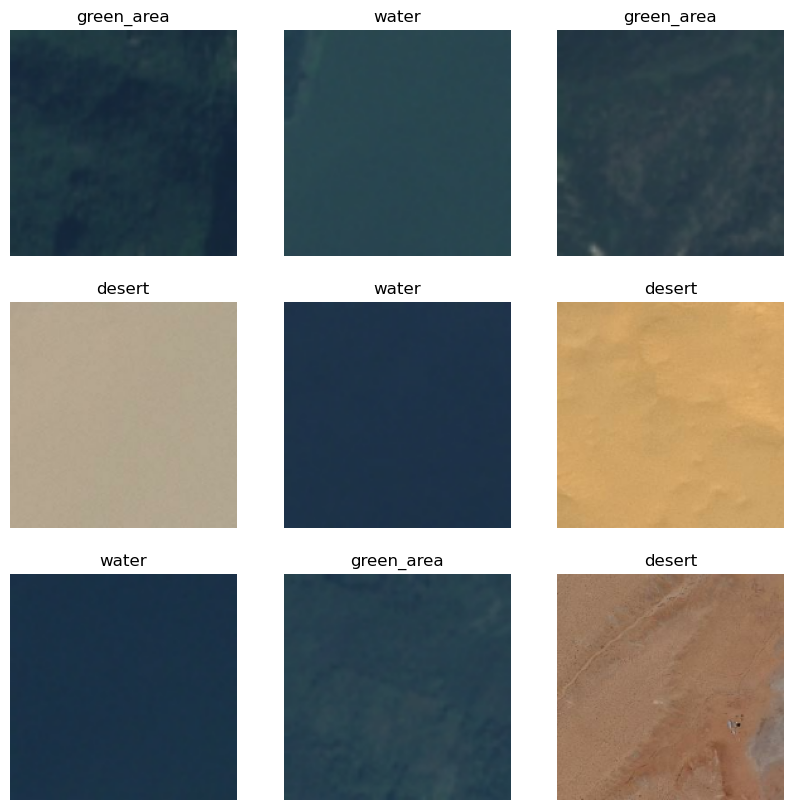

In [18]:
# Load Dataset with TensorFlow
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


categories = ['cloudy', 'desert', 'green_area', 'water']
flat_data_arr = [] #input array
target_arr = [] #output array
datadir = dataset_path

# --------
# Normalize and cache datasets
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_dataset(ds):
    return ds.map(lambda x, y: (x / 255.0, y), num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

train_ds = preprocess_dataset(train_ds)
val_ds = preprocess_dataset(val_ds)

# Extract features and labels for SVM
def extract_features_and_labels(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        features.extend(images.numpy())
        labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

x_train, y_train = extract_features_and_labels(train_ds)
x_val, y_val = extract_features_and_labels(val_ds)

# Flatten images for SVM
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)

# Dimensionality reduction with PCA
pca = PCA(n_components=50, random_state=77)
x_train_pca = pca.fit_transform(x_train_flat)
x_val_pca = pca.transform(x_val_flat)

# Train SVM with GridSearch
param_grid = {
    'C': [0.1, 1, 10, 100], 
    'gamma': [0.0001, 0.001, 0.1, 1], 
    'kernel': ['rbf', 'poly']
}
svc = svm.SVC(probability=True)
model = GridSearchCV(svc, param_grid)

model.fit(x_train_pca, y_train)
print("SVM Model Trained Successfully.")

# --------

# Evaluate the model [new]
y_pred = model.predict(x_val_pca)
print(classification_report(y_val, y_pred, target_names=categories))

### 1.2 Unsupervised<a id="section_1_2"></a>
#### Pattern Identification 1.2.1 <a id="sub_section_1_2_1"></a>

In [19]:
# Define a region in which to generate a segmented map.
region = ee.Geometry.Rectangle(29.7, 30, 32.5, 31.7)

# Load a Landsat composite for input.
input = (
    ee.ImageCollection('LANDSAT/COMPOSITES/C02/T1_L2_32DAY')
    .filterDate('2001-05', '2001-06')
    .first()
    .clip(region)
)

# Display the sample region.
m = geemap.Map()
m.set_center(31.5, 31.0, 8)
m.add_layer(ee.Image().paint(region, 0, 2), {}, 'region')

# Make the training dataset.
training = input.sample(region=region, scale=30, numPixels=5000)

# Instantiate the clusterer and train it.
clusterer = ee.Clusterer.wekaKMeans(15).train(training)

# Cluster the input using the trained clusterer.
result = input.cluster(clusterer)

# Display the clusters with random colors.
m.add_layer(result.randomVisualizer(), {}, 'clusters')
m

Map(center=[31.0, 31.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

## 2. Segmentation<a id="chapter2"></a>
### Data preprocess 2.1 <a id="section_2_1"></a>

(-0.5, 255.5, 255.5, -0.5)

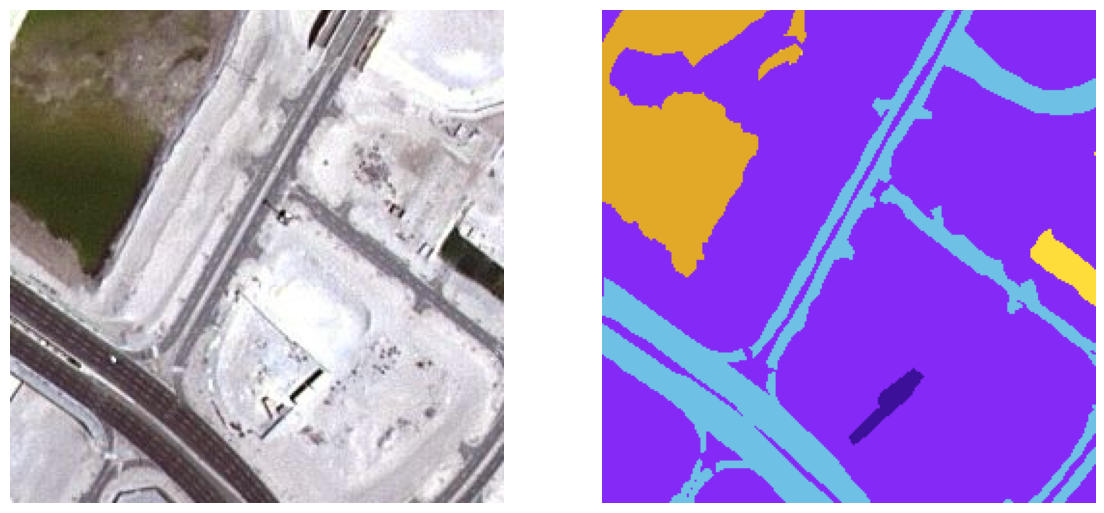

In [21]:
dataset_root = 'Datasets/Segmentation_Tasks/Semantic segmentation dataset'
image = cv2.imread(f'{dataset_root}/Tile 2/images/image_part_001.jpg', 1)
image.shape

# patchfy can split images into small overlappable patches by given patch cell size, and merge patches into original image.
# This will split the image into small images of shape [3,3]
image_patch_size = 256
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
len(image_patches)

# Store processed image patches in arrays
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
      
  elif image_type == 'masks':
     image_extension = 'png'
      
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
        
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # Dimensions are cropped to the nearest multiple of image_patch_size for both width and height  
        size_x = (image.shape[1]//image_patch_size) * image_patch_size
        size_y = (image.shape[0]//image_patch_size) * image_patch_size
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        image = np.array(image)
        # Divide into smaller patches of size
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
          
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            # Scale between 0 and 1
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              image_dataset.append(individual_patched_image)
                
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.axis('off')
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])
plt.axis('off')

### One-hot encoding 2.2 <a id="section_2_2"></a>

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


6

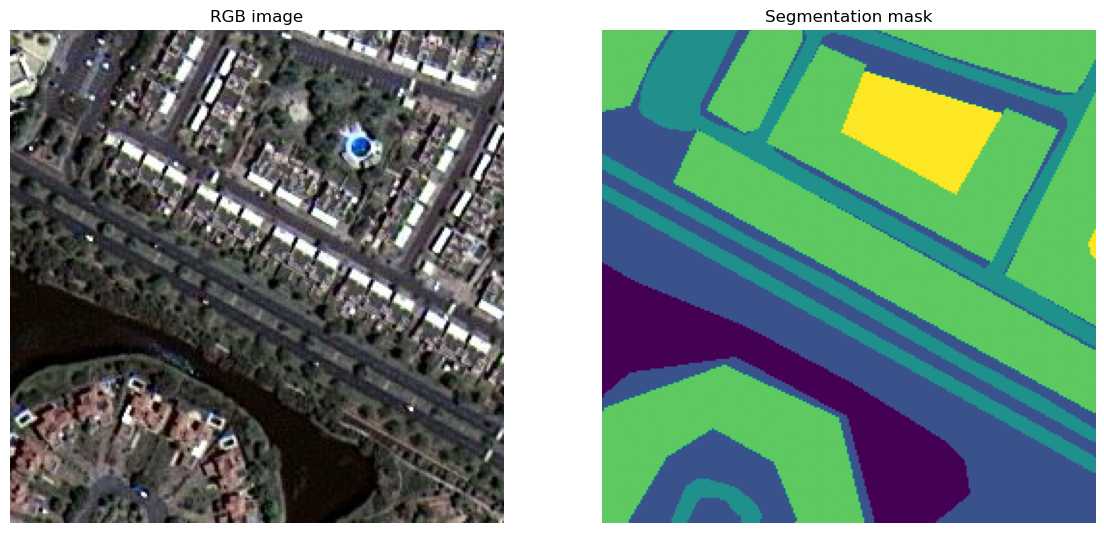

In [24]:
# One-hot encoding
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

label = individual_patched_mask

def rgb_to_label(label):
    '''
    The function translates human-readable RGB masks into numerical format required for training and evaluation.
    Args:
        label: An RGB-encoded mask image, where each pixel has an RGB value corresponding to a specific class (e.g., buildings, water, etc.).
    '''
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
      
    label_segment = label_segment[:,:,0]
      
    return label_segment

labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

np.unique(labels)

random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.title("RGB image")
plt.axis('off')
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.title("Segmentation mask")
plt.axis('off')
plt.imshow(labels[random_image_id][:,:,0])

total_classes = len(np.unique(labels))
total_classes

### Architecture 2.3 <a id="section_2_3"></a>

In [26]:
labels_cat_dataset = to_categorical(labels, num_classes = total_classes)
training_dataset = image_dataset

X_train, X_test, y_train, y_test = train_test_split(training_dataset, labels_cat_dataset, test_size=0.15, random_state=100)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

# define Jaccard function with training data
def jaccard_coef(y_true, y_pred):
    '''Computes the Jaccard coefficient.
    Args:
        y_true: Ground truth binary mask (or set of values).
        y_pred: Predicted binary mask (or set of values).
    '''
    y_true_flatten = tf.keras.backend.flatten(y_true)
    y_pred_flatten = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (tf.keras.backend.sum(y_true_flatten) + tf.keras.backend.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value


# Build model
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):
    '''
    Defines a U-Net architecture for semantic segmentation and consists of an encoder-decoder architecture, where the encoder extracts features from the image and the decoder reconstructs the image to output a segmentation map used for image segmentation.
    Args:
        n_classes: The number of output classes for segmentation (e.g., 5).
        image_height, image_width: The dimensions of the input image (default 256x256).
        image_channels: The number of channels in the input image (default 1, for grayscale).
    '''
    
    inputs = Input((image_height, image_width, image_channels))

    source_input = inputs

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define metrics
metrics = ["accuracy", jaccard_coef]

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

model = get_deep_learning_model()

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)
256
256
3
6
256
256
3
6


### Loss Function 2.4 <a id="section_2_4"></a>

In [28]:
# Define loss function and weights
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
# Generate dice loss by passing the weights
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

### Model Compliation 2.5 <a id="section_2_5"></a>

In [29]:
tf.keras.backend.clear_session()
# Adam optimizer for classification
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)
# Generate model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 256, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 16)      │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 16)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128, 128, 32)      │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64, 64, 64)        │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 32, 32, 128)       │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 128)       │         147,584 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_history = model.fit(X_train, y_train,
                          batch_size = 16, # 45 - 50 images will be processed each time
                          verbose = 1,
                          epochs = 25, # update epochs for better results
                          validation_data = (X_test, y_test),
                          shuffle = False)

Epoch 1/25


C:\Users\zhech\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.4082 - jaccard_coef: 0.1808 - loss: 1.0162 - val_accuracy: 0.6440 - val_jaccard_coef: 0.2846 - val_loss: 0.9958
Epoch 2/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6730 - jaccard_coef: 0.3142 - loss: 0.9941 - val_accuracy: 0.6715 - val_jaccard_coef: 0.3608 - val_loss: 0.9770
Epoch 3/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.6867 - jaccard_coef: 0.4096 - loss: 0.9719 - val_accuracy: 0.6913 - val_jaccard_coef: 0.4324 - val_loss: 0.9756
Epoch 4/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7135 - jaccard_coef: 0.4573 - loss: 0.9635 - val_accuracy: 0.6918 - val_jaccard_coef: 0.4693 - val_loss: 0.9695
Epoch 5/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.7445 - jaccard_coef: 0.5083 - loss: 0.9547 - val_accuracy: 0.7090 - val_jaccard_coef: 0.4955 - val_loss: 0.9623
Epoch 6/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7745 - jaccard_coef: 0.5571 - loss: 0.9445 - val_accuracy: 0.6924 

### Evaluation 2.6 <a id="section_2_6"></a>

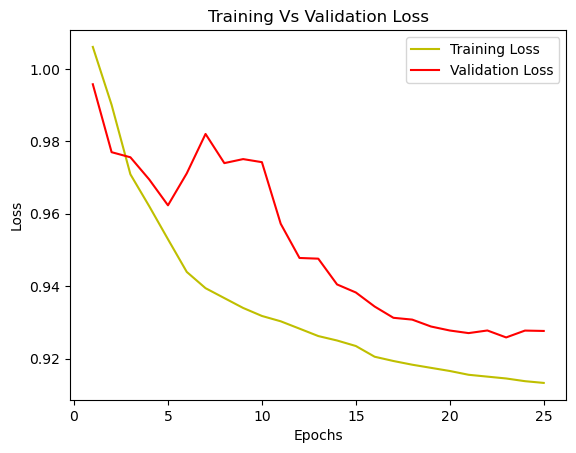

In [34]:
history_a = model_history
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot model history
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

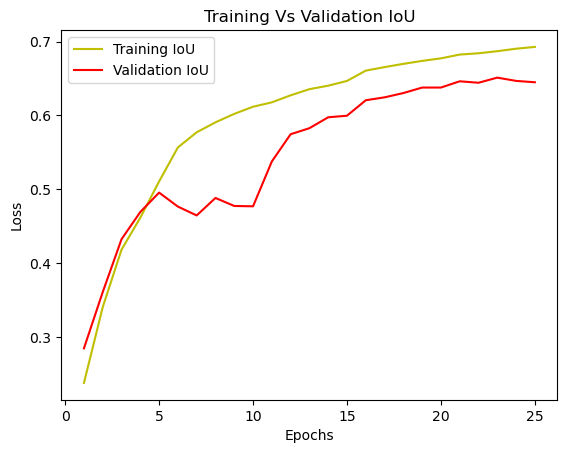

In [35]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

# Plot for Jaccard coef
epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Prediction 2.7 <a id="section_2_7"></a>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


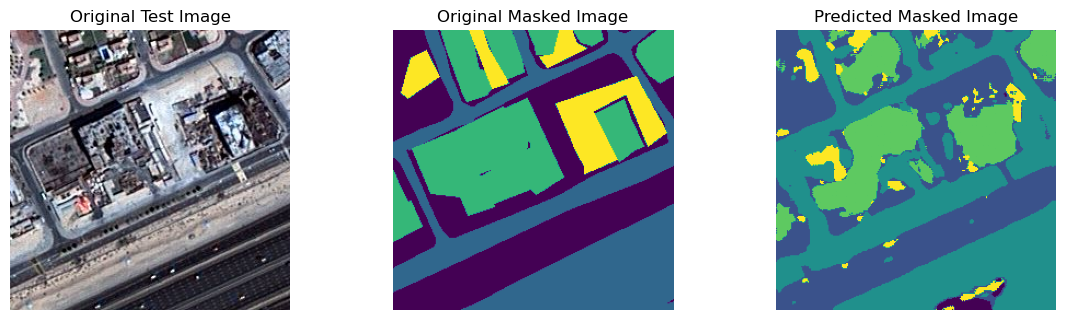

In [37]:
y_test_argmax = np.argmax(y_test, axis=3)

test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number] # our mask
text_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(text_image_input)
predicted_image = np.argmax(prediction, axis = 3)
predicted_image = predicted_image[0, :, :]

# Plot  prediction - actial image, actual mask and predicted mask
plt.figure(figsize = (14, 8))

plt.subplot(231)
plt.title("Original Test Image")
plt.axis('off')
plt.imshow(test_image)

plt.subplot(232)
plt.title("Original Masked Image")
plt.axis('off')
plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title("Predicted Masked Image")
plt.axis('off')
plt.imshow(predicted_image)

## Other Implementations 3 <a id="chapter3"></a>
### Earth Engine 3.1 <a id="section_3_1"></a>
#### Data Collection 3.1.1 <a id="sub_section_3_1_1"></a>

In [45]:
def load_geotiff_img_advanced(img_path, new_img_name, selected_bands=None):
    """
    Loads, normalizes, resizes, and saves GeoTIFF images for model training.
    Works for single-band (e.g., NDVI) or multi-band images. 
    Ensures output shape is (256, 256, bands).
    """
    with rasterio.open(f'Datasets/{img_path}') as src:
        # Determine the bands to process
        num_bands = src.count
        bands_to_process = selected_bands if selected_bands else range(1, num_bands + 1)
        nodata_value = src.nodata

        # Initialize list to store resized bands
        resized_bands = []

        for band_idx in bands_to_process:
            # Read the band
            band_data = src.read(band_idx)

            # Handle no-data values
            if nodata_value is not None:
                band_data = np.where(band_data == nodata_value, np.nan, band_data)

            # Normalize the band
            band_clipped = np.clip(band_data, -1, 1) if selected_bands == ['NDVI'] else band_data
            band_normalized = (band_clipped + 1) / 2 if selected_bands == ['NDVI'] else band_data

            # Resize the band to 256x256
            band_resized = resize(band_normalized, (256, 256), mode='reflect', anti_aliasing=True).astype(np.float32)
            resized_bands.append(band_resized)

        # Stack bands for multi-band output
        resized_image = np.stack(resized_bands, axis=-1)  # Shape: (256, 256, bands)
        
        # Adjust transform for resizing
        transform_resized = src.transform * src.transform.scale(
            src.width / 256, src.height / 256
        )

        # Save the resized image
        with rasterio.open(
            new_img_name,
            'w',
            driver='GTiff',
            height=256,
            width=256,
            count=resized_image.shape[-1],  # Number of bands
            dtype='float32',
            crs=src.crs,
            transform=transform_resized,
        ) as dst:
            for i in range(resized_image.shape[-1]):  # Loop over bands
                dst.write(resized_image[:, :, i], i + 1)  # Write each band

        print(f"Saved resized image with {resized_image.shape[-1]} band(s) to {new_img_name}.")


In [39]:
# define a year to be used [used for further processing]
year = 2013
dataset_image_land_07 = ee.Image('LANDSAT/LE07/C02/T1_TOA/LE07_195027_19990725').select(
    ['B3', 'B2', 'B1']
)

dataset_land_07 = ee.ImageCollection('LANDSAT/LE07/C02/T1_TOA').filterDate(
    '2001-01-01', '2002-12-31'
).select(['B3', 'B2', 'B1'])
trueColor321 = dataset_land_07.select(['B3', 'B2', 'B1'])
trueColor321Vis = {
    'min': 0.0,
    'max': 0.4,
    'gamma': 1.2,
}
m = geemap.Map()
m.set_center(6.746, 46.529, 6)
m.add_layer(trueColor321, trueColor321Vis, 'True Color (321)')
m

Map(center=[46.529, 6.746], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

In [40]:
dataset_image_land_08 = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_199027_20170831').select(
    ['B3', 'B2', 'B1']
)

dataset_land_08 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA').filterDate(
    f'{year}-01-01', f'{year}-12-31'
).select(['B4', 'B5', 'B2'])
true_color_432 = dataset_land_08.select(['B4', 'B5'])
true_color_432_vis = {
    'min': 0.0,
    'max': 0.4,
}
m = geemap.Map()
m.set_center(6.746, 46.529, 6)
m.add_layer(true_color_432, true_color_432_vis, 'True Color (432)')
m

Map(center=[46.529, 6.746], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

#### Image Preprocess, Export and Load 3.1.2 <a id="sub_section_3_1_2"></a>

In [64]:
debug_enabled = False

In [59]:
point = ee.Geometry.Point([40.28, 61.28])

# Create a buffer of 5 kilometers
buffer = point.buffer(5000)

# Use the buffer or the point as the region for export
geometry = buffer.bounds()

dataset_land_08.size()

# Export the image, specifying the CRS, transform, and region.
def export_task (dataset, geometry, description):
    task = ee.batch.Export.image.toDrive(
        image=dataset,
        description=description,
        # crs=projection.get('crs'),
        # crsTransform=projection['transform'],
        scale=30, # 30 for Landsat
        region=geometry,
        maxPixels=1e13  # Increase max pixels to allow large exports
    )
    task.start()

In [43]:
# Define a function to export each batch
def export_monthly_batch(collection, start_date, end_date, batch_id):
    # Filter collection by date
    monthly_collection = collection.filterDate(start_date, end_date) 
    
    # Create a composite image for the batch
    composite_image = monthly_collection.median()

    task = export_task(composite_image, geometry, 'Landsat_08_NDVI_Export_13')

    if debug_enabled:
        print(f"Exporting batch {batch_id} from {start_date} to {end_date}")

# Define the list of monthly batches
dates = [
    (f'{year}-01-01', f'{year}-01-31'),
    (f'{year}-02-01', f'{year}-02-28'),
    (f'{year}-03-01', f'{year}-03-31'),
    (f'{year}-04-01', f'{year}-04-30'),
    (f'{year}-05-01', f'{year}-05-31'),
    (f'{year}-06-01', f'{year}-06-30'),
    (f'{year}-07-01', f'{year}-07-31'),
    (f'{year}-08-01', f'{year}-08-31'),
    (f'{year}-09-01', f'{year}-09-30'),
    (f'{year}-10-01', f'{year}-10-31'),
    (f'{year}-11-01', f'{year}-11-30'),
    (f'{year}-12-01', f'{year}-12-31')
]

In [ ]:
# Loop over each date range and export each month as a separate batch
for i, (start_date, end_date) in enumerate(dates):
    export_monthly_batch(dataset_land_08, start_date, end_date, i+1)

In [ ]:
# Images to be formatted folder name
folder_name = 'Resize_function'
# loop through all downloaded images and save for model training
directory_data = os.fsencode(r"C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Landsat\{}".format(folder_name))

for file in os.listdir(directory_data):
    filename = os.fsdecode(file)
    load_geotiff_img_advanced("Landsat/Resize_function/{}".format(filename), "Datasets/Model_Ready/{}".format(filename))


In [46]:
# Define Image Loading and Preprocessing Functions
def load_geotiff(filepath):
    with rasterio.open(filepath) as src:
        # Read all bands and return as numpy array
        image = src.read()  # Shape: (bands, height, width)
    return image

def preprocess_image(image):
    # Check the shape of the image
    if image.ndim == 3:
        if image.shape[0] == 1:  # Shape: (1, height, width)
            # Single-channel grayscale image, remove the first dimension and expand to 3 channels
            image = np.stack((image[0],) * 3, axis=-1)  # Shape becomes (height, width, 3)
        elif image.shape[0] == 3 and image.shape[1:] != image.shape[0:1]:  # Shape: (3, height, width)
            # Convert to (height, width, 3)
            image = np.transpose(image, (1, 2, 0))  # Swap axes to (height, width, bands)
        elif image.shape[2] == 3:  # Shape: (height, width, 3)
            pass  # Already in the correct format
        else:
            raise ValueError("Unexpected 3D image shape: {}".format(image.shape))
    elif image.ndim == 2:  # Grayscale image (height, width)
        # Convert grayscale to 3 channels by stacking
        image = np.stack((image,) * 3, axis=-1)  # Shape becomes (height, width, 3)
    else:
        raise ValueError("Unexpected image dimensions: {}".format(image.ndim))

    return image.astype(np.float32) / 255.0  # Normalize to [0, 1]

In [65]:
# Directory containing GeoTIFF images
directory_model_data = r"C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready"

for file in os.listdir(directory_model_data):
    # Construct the full file path
    filename = os.path.join(directory_model_data, file)

    # Print the filename to debug
    if debug_enabled:
        print("Loading file:", filename)

    # Load and preprocess each image
    try:
        # Check if it's a file, not a directory
        if os.path.isfile(filename):
            image = load_geotiff(filename)
            processed_image = preprocess_image(image)
            if debug_enabled:
                print("Processed image shape:", processed_image.shape)
    except Exception as e:
        print(f"Error processing {filename}: {e}")


labels_dict = {}
for filename in os.listdir(directory_model_data):
    if filename.endswith(".tif"):
        # Example label extraction logic, modify according to your naming convention
        label = int(filename.split("_")[1].split(".")[0])  # Extract label from filename
        labels_dict[filename] = label

if debug_enabled:
    print(labels_dict)

In [66]:
# Filepaths to the images
filepaths_tif = glob.glob(directory_model_data + "/*.tif")
# Total number of samples
total_samples = len(filepaths_tif)

# Generator function to load and preprocess each image
def data_generator(filepaths, labels_dict):
    for filepath in filepaths:
        image = load_geotiff(filepath)  # Load the GeoTIFF image
        image = preprocess_image(image)   # Preprocess the image

        if debug_enabled:
            print(f"Image shape before yielding: {image.shape}")  # Debugging line

        # Convert the image to a TensorFlow tensor
        image = tf.convert_to_tensor(image, dtype=tf.float32)

        # If image is (256, 256, 1), convert it to (256, 256, 3)
        if image.shape[-1] == 1:
            image = tf.image.grayscale_to_rgb(image)

        # Extract filename and get the corresponding label
        filename = os.path.basename(filepath)
        label = labels_dict.get(filename)

        # Skip if no label is found
        if label is None:
            continue
        
        # Convert label to a TensorFlow tensor
        label = tf.convert_to_tensor(label, dtype=tf.float32)

        if debug_enabled:
            print("Yielding image shape:", image.shape, "and label:", label)
            
        yield image, label

# Create the dataset using a lambda function to pass labels_dict
dataset_land_t = tf.data.Dataset.from_generator(
    lambda: data_generator(filepaths_tif, labels_dict),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),  # Image shape
        tf.TensorSpec(shape=(), dtype=tf.float32)  # Label shape
    )
)

# Shuffle, batch, and prefetch the dataset for efficient training
dataset_land_t = dataset_land_t.shuffle(buffer_size=len(filepaths_tif)).batch(32).prefetch(tf.data.AUTOTUNE)

# Check dataset shapes
for images, labels in dataset_land_t.take(1):
    print("Image batch shape:", images.shape)  # Should be (32, 256, 256, 3)
    print("Label batch shape:", labels.shape)  # Should be (32,)

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)


#### Model Training 3.1.3 <a id="sub_section_3_1_3"></a>

In [67]:
# Define input shape for Landsat imagery
input_shape = (256, 256, 3)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    # Data Augmentation
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    
    # Convolutional layers
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'), # input_shape=input_shape
    # BatchNormalization layers after convolutional layers to stabilize training and improve performance
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),

    # Dense layers
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # For regression tasks
])

model.summary()

#  Split the Dataset into Training and Validation Sets 
# train_size = int(0.8 * len(filepaths_tif))
# Calculate split sizes
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

train_dataset = dataset_land_t.take(train_size) #.repeat()
val_dataset = dataset_land_t.skip(train_size) #.repeat()

# Define callbacks and monitor validation loss and prevent overfitting
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5)
]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 471,425 (1.80 MB)

 Trainable params: 470,529 (1.79 MB)

 Non-trainable params: 896 (3.50 KB)

In [68]:
# Compile the model
model.compile(optimizer='adam', loss='mse')  # MSE for regression; adjust if needed

# Train the model
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - loss: 3002.5518 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 3124.4839 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 3162.0139 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 2790.5476 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 2647.4253 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 2528.7100 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 2073.2727 - learning_rate: 0.0010
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 1688.5869 - learning_rate: 0.0010
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 1112.5248 - learning_rate: 0.0010
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 858.9059 - learning_rate: 0.0010
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 847.8320 - learning_rate: 0.0010
Epoch 12/5

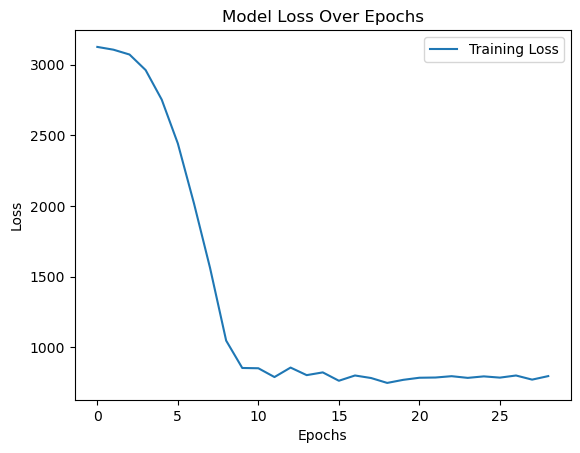

In [69]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Explore Model Architectures 3.1.4 <a id="sub_section_3_1_4"></a>

In [70]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze the base model

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

In [ ]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

In [71]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 262, 262, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 128, 128, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 128, 128, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 128, 128, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 130, 130, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 64, 64, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 64, 64, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 64, 64, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [72]:
# Add custom layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='linear')  # Regression task
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)